In [8]:
# It's good practice to keep track of the versions of various packages you are using
import rioxarray
import xarray as xr
import rasterio
import numpy as np
import os

print('rioxarray version:', rioxarray.__version__)
print('xarray version:', xr.__version__)
print('rasterio version:', rasterio.__version__)

# Work in a temporary directory
os.chdir('/tmp')

# Plotting setup
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
#plt.rcParams.update({'font.size': 16}) # make matplotlib font sizes bigger
print('\nDone')

rioxarray version: 0.4.3
xarray version: 0.18.2
rasterio version: 1.2.6

Done


In [7]:
# # Rasterio has some capabilities to read URLs in addition to local file paths
# #url = 's3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif'
# #!aws s3 ls s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2017_016_078_0003d/
# input_tif = '/tmp/grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.tiff'
# output_cog = 's3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2017_016_078_0003d/grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.TIF'
# !gdal_translate -of COG -co COMPRESS=DEFLATE -co GEOTIFF_VERSION=1.1 -a_nodata 0 {input_tif} {output_cog}

Input file size is 1592, 7187
ERROR 4: Attempt to create new tiff file `s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2017_016_078_0003d/grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.TIF.ovr.tmp' failed in VSI_TIFFOpen().


In [9]:
# Rasterio has some capabilities to read URLs in addition to local file paths
#url = 's3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif'

url = 's3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_008_274_0007d/grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff'

# need to use environment variables to change default GDAL settings when reading URLs
Env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                   AWS_NO_SIGN_REQUEST='YES')
#daC = rioxarray.open_rasterio(src).squeeze('band', drop=True)
#NOTE: this reads metadata only
with Env:
    with rasterio.open(url) as src:
        print(src.profile)

RasterioIOError: '/vsis3/snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_008_274_0007d/grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff' not recognized as a supported file format.

In [33]:
!aws s3 cp s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2017_016_078_0003d/grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.tiff ./
    

download: s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2017_016_078_0003d/grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.tiff to ./grmesa_07805_17016-000_17018-000_0003d_s01_L090HH_01.cor.grd.tiff


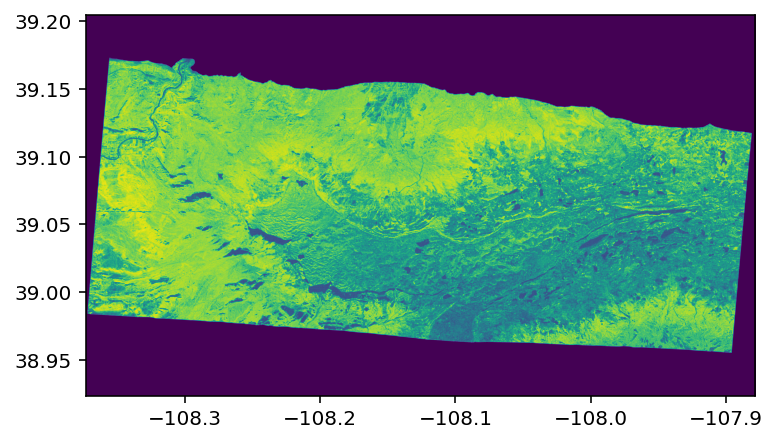

<AxesSubplot:>

In [9]:
!aws s3 cp s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_008_274_0007d/grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff ./
from rasterio.plot import show
src = rasterio.open('grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff')
show(src)

In [12]:
import json
import os
import rasterio as rio
import rioxarray
import hvplot.xarray

In [16]:
s3_path = 's3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_008_274_0007d/grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff'

In [13]:
%%bash 
# Set up temporary credentials for GDAL
# https://github.com/OSGeo/gdal/issues/4058
# NOTE: these last for 1 hour
aws sts assume-role-with-web-identity \
 --role-arn $AWS_ROLE_ARN \
 --role-session-name snowex \
 --web-identity-token file://$AWS_WEB_IDENTITY_TOKEN_FILE \
 --duration-seconds 3600 > /tmp/irp-cred.json

# Print out creds    
#echo AWS_REGION="us-west-2"
#echo AWS_ACCESS_KEY_ID="$(cat /tmp/irp-cred.json | jq -r ".Credentials.AccessKeyId")"
#echo AWS_SECRET_ACCESS_KEY="$(cat /tmp/irp-cred.json | jq -r ".Credentials.SecretAccessKey")"
#echo AWS_SESSION_TOKEN="$(cat /tmp/irp-cred.json | jq -r ".Credentials.SessionToken")"

In [18]:
# Use temporary credentials in python (rasterio)

with open('/tmp/irp-cred.json') as f:
    creds = json.load(f)
    AccessKeyId = creds['Credentials']['AccessKeyId']
    SecretAccessKey = creds['Credentials']['SecretAccessKey']
    SessionToken = creds['Credentials']['SessionToken']
    
    # Set environment variables
    os.environ['AWS_ACCESS_KEY_ID'] = AccessKeyId
    os.environ['AWS_SECRET_ACCESS_KEY'] = SecretAccessKey
    os.environ['AWS_SESSION_TOKEN'] = SessionToken

# GDAL env variables https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access
Env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',AWS_NO_SIGN_REQUEST='YES')

In [23]:
# Now you can read it directly and work with subsets, etc
import rioxarray
with Env:
    da = rioxarray.open_rasterio(s3_path)

da.name = os.path.basename(s3_path)
da

RasterioIOError: '/vsis3/snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_008_274_0007d/grmesa_27416_20008-004_20013-004_0007d_s01_L090HH_01.cor.grd.tiff' not recognized as a supported file format.

In [27]:

# Efficiently plot in browser
import hvplot.xarray
da.hvplot.image(rasterize=True, cmap='gray')

NameError: name 'da' is not defined

In [28]:

#http://xarray.pydata.org/en/stable/user-guide/indexing.html
# Use da.sel to use geo coordinates
subset = da.isel(x=slice(1000,2000), y=slice(4000,4500))
subset

NameError: name 'da' is not defined